In [1]:
import os
import time
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2

from src import UNet,VGG16UNet,CabmUnet

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cpu device.


## 指定各个类别的配色方案

In [3]:
# 各类别的配色方案（BGR）
palette = [
    ['background', [127,127,127]],
    ['obstraction', [0,0,255]],
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

## 使用标准Unet模型进行训练

In [5]:
classes = 1  # exclude background
weights_path = "./save_weight/best_thrombus_model.pth"
# create model
model = UNet(in_channels=3, num_classes=classes+1, base_c=32, bilinear=False)
# load weights
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
model.to(device)

UNet(
  (in_conv): DoubleConv(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Down(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dow

## 使用VGG16UNet

In [ ]:
classes = 1  # exclude background
weights_path = "./save_weights/VGG16UNet.pth"
# create model
model = VGG16UNet(num_classes=classes + 1,pretrain_backbone=False)
# load weights
model.load_state_dict(torch.load(weights_path, map_location='cpu')["model"])
model.to(device)

## MobileV3Unet

In [ ]:
classes = 1  # exclude background
weights_path = "./save_weights/MobileV3Unet.pth"
# create model
model = MobileV3Unet(num_classes=classes + 1,pretrain_backbone=False)
# load weights
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
model.to(device)

## CabmUnet

In [ ]:
classes = 1  # exclude background
weights_path = "./save_weights/best_model.pth"
# create model
model = CabmUnet(in_channels=3, num_classes=2, bilinear=False, base_c=32)
# load weights
model.load_state_dict(torch.load(weights_path, map_location='cpu')['model'])
model.to(device)

## 单张图像预测函数

In [6]:
opacity = 0.3 # 透明度，越大越接近原图

# mean = (0.540, 0.539, 0.541)
# std = (0.204,0.203,0.202)

outputs_path = "./output/"
mean = (0.541, 0.601, 0.692)
std = (0.096, 0.108, 0.142)


In [7]:
def process_single_img(img_path,save=False):
    # load image
    original_img = cv2.imread(img_path)

    # from pil image to tensor and normalize
    data_transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=mean, std=std)])
    img = data_transform(original_img)
    # expand batch dimension
    img_bgr = torch.unsqueeze(img, dim=0)

    # 语义分割预测
    model.eval()  # 进入验证模式
    with torch.no_grad():
        # init model
        img_height, img_width = img_bgr.shape[-2:]
        init_img = torch.zeros((1, 3, img_height, img_width), device=device)
        model(init_img)

        output = model(img_bgr.to(device))

        prediction = output['out'].argmax(1).squeeze(0)
        pred_mask = prediction.to("cpu").numpy().astype(np.uint8)

    # 将预测的整数ID，映射为对应类别的颜色
    pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
    for idx in palette_dict.keys():
        pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
    pred_mask_bgr = pred_mask_bgr.astype('uint8')

    # 将语义分割预测图和原图叠加显示
    pred_viz = cv2.addWeighted(original_img, opacity, pred_mask_bgr, 1-opacity, 0)
    
    # 保存图像至 outputs/testset-pred 目录
    if save:
        save_path = os.path.join(outputs_path, 'pred1-'+img_path.split('/')[-1])
        # save_path = os.path.join(''../','../','../','outputs', 'testset-pred'', 'pred-'+img_path.split('/')[-1])
        print(save_path)
        cv2.imwrite(save_path, pred_viz)
    
    return pred_mask_bgr

## 测试集批量预测

In [11]:
img_path = "./data/thrombus/img_dir/val/"
# img_path = "/Users/chenchaofan/Desktop/data/tif/test_img"
os.listdir(path=img_path)

['15.jpg', '16.jpg', '13.jpg', '18.jpg', '2.jpg']

In [12]:
for each in tqdm(os.listdir(path=img_path)):
    img_file = img_path + each
    # print(img_file)
    process_single_img(img_file, save=True)

 20%|██        | 1/5 [00:16<01:07, 16.76s/it]

./output/pred1-15.jpg


 40%|████      | 2/5 [00:30<00:45, 15.15s/it]

./output/pred1-16.jpg


 60%|██████    | 3/5 [00:44<00:29, 14.68s/it]

./output/pred1-13.jpg


 80%|████████  | 4/5 [00:58<00:14, 14.30s/it]

./output/pred1-18.jpg


100%|██████████| 5/5 [01:12<00:00, 14.57s/it]

./output/pred1-2.jpg


### 识别一张图片并显示

In [20]:
import matplotlib.pyplot as plt

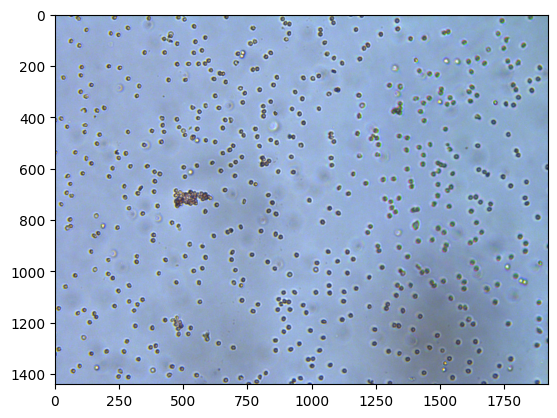

In [21]:
img_file = "./testImage/13.jpg"
img_bgr=cv2.imread(img_file)
plt.imshow(img_bgr[:,:,::-1])
plt.show()

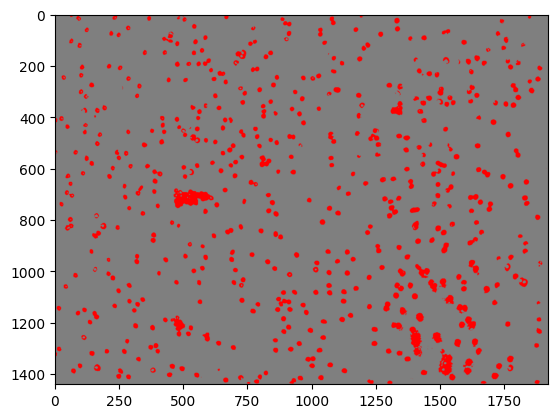

In [27]:
viz_mask_bgr=process_single_img(img_path=img_file,save=False)
plt.imshow(viz_mask_bgr[:,:,::-1])
plt.show()

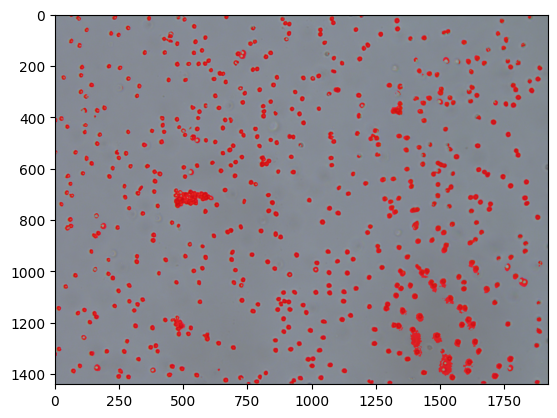

In [29]:
opacity = 0.5 # 透明度，越大越接近原图
img_bgr = cv2.addWeighted(img_bgr, opacity, viz_mask_bgr, 1-opacity, 0)
plt.imshow(img_bgr[:,:,::-1])
plt.show()